# Review

In the previous notebook (`2_model-training.ipynb`), we:

1. Implemented our version of U-Net
1. Setup model training loop
1. Train the model
1. Create an inferencing pipeline
1. Make an inferencing from the trained model

That was a lot of scripting on the previous module. In this module, we will rest our finger a bit and touch our analytical side, because we are going to do some experimentation!

# Task 1: Initial Setup

## Importing Libaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os


notebook_path = os.path.join(os.getcwd())

In [3]:
%%capture
!pip install rasterio

In [4]:
import os
import sys
from pathlib import Path

# Import from your package
sys.path.append(str(Path(notebook_path)))

## Preparing Directories

In [5]:
import shutil
from glob import glob

NB_DIR = Path(notebook_path)
PROJECT_DIR = NB_DIR

DATA_DIR = os.path.join(PROJECT_DIR ,"nb", 'data')
print(f"Data directory: {DATA_DIR}")
RAW_DATA_DIR = os.path.join(DATA_DIR,'0_raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, '1_interim')
PATCH_DIR = os.path.join(DATA_DIR , '2_patches')

# Define source and destination directories
dst_dir = str(DATA_DIR)
src_dir = '/content/drive/MyDrive/Drone-Image-DL-Classification'
src_dir
# Copy the data directory to Google Drive
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"Copied {src_dir} to {dst_dir}")

print(f'Patch directory: {PATCH_DIR}')

print(f"Project directory: {PROJECT_DIR}")
folder_list = [
    DATA_DIR,
    RAW_DATA_DIR,
    INTERIM_DATA_DIR,
    PATCH_DIR,
]

for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

RANDOM_SEED = 42

Data directory: /content/nb/data
Copied /content/drive/MyDrive/Drone-Image-DL-Classification to /content/nb/data
Patch directory: /content/nb/data/2_patches
Project directory: /content


## Requirements

In this module, we will use MLFlow to track our experiments. If you are running it locally, everything is set for you. However, if you run it in google colab, you need to have an auth key from [**ngrok**](https://ngrok.com/).

1. Visit this website<br>
https://ngrok.com/
2. You can sign up using your email, then sign in.

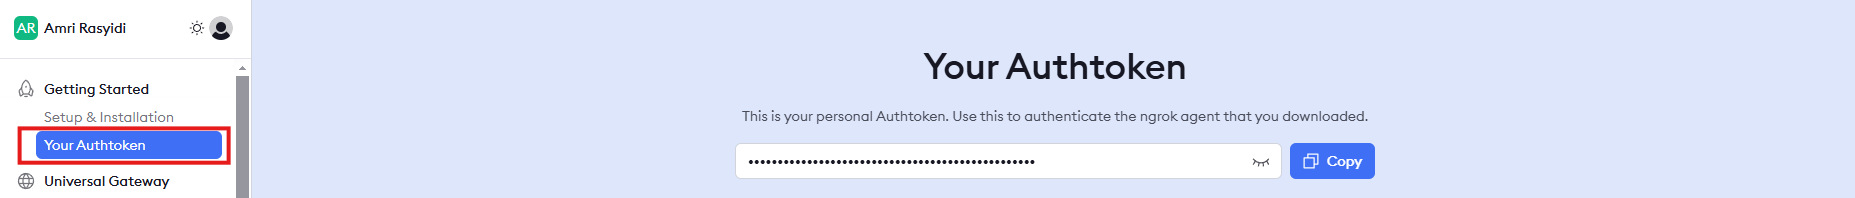

3. After that, navigate to the "Your Authtoken" page
4. Copy your authtoken
5. Put it in the cell below inside the " ".

In [6]:
ngrok_auth = "2w1BaaLxXberIIWJTPdBIGBUDC5_5fEbaS1fVwWpgaYSceA8E" ## pyani account (test)

**NOTE: THIS IS NOT A GOOD PRACTICE OF STORING CREDENTIAL SUCH AS AUTH TOKEN.<br>
But for practicality, we will do it this way anyway.**

**Reset Token**<br>
Once you finish with this module, you should go back to the "Your Authtoken" page in ngrok dashboard, scroll down, and click "Reset Authtoken" to ensure your token is safe.

## Bringing DataLoader From Previous Notebook

In [7]:
import os
from random import randint

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


class BuildingsDroneDataset(Dataset):
    """Dataset for building segmentation from drone imagery.

    Args:
        patch_dir (str): path to patch images folder (TIF format)
        label_dir (str): path to label masks folder (TIF format)
        augmentation (albumentations.Compose): data transformation pipeline
        preprocessing (albumentations.Compose): data preprocessing
    """

    def __init__(
        self,
        patch_dir,
        label_dir,
        augmentation=None,
        preprocessing=None,
    ):
        # Get paths to all TIF files in the directories
        self.patch_paths = [
            os.path.join(patch_dir, file_name)
            for file_name in sorted(os.listdir(patch_dir))
            if file_name.endswith(".tif")
        ]

        self.label_paths = [
            os.path.join(label_dir, file_name)
            for file_name in sorted(os.listdir(label_dir))
            if file_name.endswith(".tif")
        ]

        # Verify that we have matching number of patches and labels
        assert len(self.patch_paths) == len(
            self.label_paths
        ), f"Number of patches ({len(self.patch_paths)}) and labels ({len(self.label_paths)}) don't match"

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read TIF images using rasterio
        with rio.open(self.patch_paths[i]) as patch_file:
            # Read all bands and transpose to (channels, height, width)
            patch = patch_file.read()
            # Convert to (height, width, channels) for albumentations
            patch = np.transpose(patch, (1, 2, 0))

        with rio.open(self.label_paths[i]) as label_file:
            # Assume mask is single channel
            mask = label_file.read(1)

        # Ensure mask has values 0 and 1 only
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=patch, mask=mask)
            patch, mask = sample["image"], sample["mask"]

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=patch, mask=mask)
            patch, mask = sample["image"], sample["mask"]

        # Convert numpy arrays to PyTorch tensors
        patch = torch.from_numpy(patch)
        mask = torch.from_numpy(mask)

        return patch, mask

    def __len__(self):
        return len(self.patch_paths)

    def plot_pair(self, idx=None):
        if idx is not None:
            idx = idx
        else:
            idx = randint(0, len(self) - 1)
        _, ax = plt.subplots(1, 2, figsize=(8, 4))

        img, mask = self[idx]

        # Convert tensors back to numpy for plotting
        img = img.numpy()
        mask = mask.numpy()

        # Handle different dimensions based on preprocessing
        if len(img.shape) == 3 and img.shape[0] == 3:  # CHW format
            img = np.transpose(img, (1, 2, 0))  # Convert to HWC for plotting

        ax[0].imshow(img)
        ax[0].set_title("Drone Image")

        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Building Mask")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        plt.suptitle(f"Sample {idx}")
        plt.tight_layout()


def get_training_augmentation():
    """
    Simple augmentation pipeline for drone imagery training data
    """
    train_transform = [
        # Basic spatial augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
    return A.Compose(train_transform)


def get_preprocessing():
    """
    Simple preprocessing function for drone imagery

    Returns:
        Preprocessing transform for normalization and channel reordering
    """

    # Define regular functions instead of lambdas
    def to_float_and_normalize(image, **kwargs):
        return image.astype(np.float32) / 255.0

    def transpose_to_chw(image, **kwargs):
        return image.transpose(2, 0, 1)

    def to_float32(mask, **kwargs):
        return mask.astype(np.float32)

    _transform = [
        # Scale to [0,1] range
        A.Lambda(image=to_float_and_normalize),
        # Convert to PyTorch format (CHW)
        A.Lambda(image=transpose_to_chw),
        # Ensure mask is float32
        A.Lambda(mask=to_float32),
    ]
    return A.Compose(_transform)


def create_dataloaders(
    patch_dir, label_dir, batch_size=8, val_split=0.2, random_state=42, num_workers=4
):
    """
    Create train and validation dataloaders

    Args:
        patch_dir: Directory containing image patches
        label_dir: Directory containing label masks
        batch_size: Batch size for dataloaders
        val_split: Validation split ratio (0.0-1.0)
        random_state: Random seed for reproducibility
        num_workers: Number of workers for DataLoader

    Returns:
        train_loader, val_loader: DataLoader objects for training and validation
    """
    # Create dataset with augmentation and preprocessing
    dataset = BuildingsDroneDataset(
        patch_dir=patch_dir,
        label_dir=label_dir,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(),
    )

    # Split dataset into training and validation
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(
        indices, test_size=val_split, random_state=random_state
    )

    # Create subset datasets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader


In [8]:
PATCH_DIR

'/content/nb/data/2_patches'

In [9]:
# Create dataset with augmentation and preprocessing
dataset = BuildingsDroneDataset(
    patch_dir=os.path.join(PATCH_DIR,'patch'),
    label_dir=os.path.join(PATCH_DIR,'label'),
)

In [10]:
# Create dataloaders
train_loader, val_loader = create_dataloaders(
    patch_dir=os.path.join(PATCH_DIR,'patch'),
    label_dir=os.path.join(PATCH_DIR,'label'),
    batch_size=2,
    num_workers=1
)

# Introduction to Experimentation in Deep Learning

Deep learning models are powerful but their performance depends heavily on the choices we make when setting up and training them. In this module, we'll explore the process of experimenting with our UNet model for drone image segmentation.

## Why experiment with hyperparameters?

Hyperparameters are the "knobs" we can turn to control how our model learns. Unlike model parameters (weights and biases) which are learned during training, hyperparameters must be set before training begins. They include:

- Learning rate
- Optimizer choice
- Batch size
- Model architecture (depth, width)
- Loss function
- Regularization techniques

Each deep learning task is unique, and there's rarely a one-size-fits-all configuration that works optimally for every problem. Finding the right hyperparameters often makes the difference between a model that performs poorly and one that achieves state-of-the-art results.

## The impact of hyperparameters on model performance

Hyperparameters can dramatically influence:
- **Training stability**: Too high learning rates can cause training to diverge, while too low rates can make training painfully slow.
- **Generalization ability**: The right hyperparameters help the model learn meaningful patterns without overfitting to training data.
- **Convergence speed**: Good hyperparameter choices can help models reach optimal performance in fewer training epochs.
- **Final performance metrics**: The difference between average and excellent performance often comes down to hyperparameter tuning.

For semantic segmentation tasks like ours, even small improvements in metrics like IoU or Dice score can translate to significantly better real-world performance in identifying buildings from drone imagery.

## Common pitfalls in deep learning experimentation

When experimenting with deep learning models, watch out for these common issues:
- **Poor experiment tracking**: Forgetting which configurations you've tried or what results they produced
- **Changing multiple hyperparameters at once**: Makes it impossible to know which change was responsible for performance differences
- **Overfitting to the validation set**: Making too many decisions based on validation performance can lead to indirect overfitting
- **Ignoring computational constraints**: Some experiments might be theoretically interesting but practically infeasible
- **Confirmation bias**: Tendency to focus on experiments that confirm our expectations

## Different ways to track machine learning experiments
There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

| Method                                     | Setup                                      | Pros                                                                         | Cons                                                                     | Cost                  |
|--------------------------------------------|--------------------------------------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------|-----------------------|
| Python dictionaries, CSV files, print outs | None                                       | Easy to setup, runs in pure Python                                           | Hard to keep track of large numbers of experiments                       | Free                  |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)                                | Minimal, install [tensorboard](https://pypi.org/project/tensorboard/)               | Extensions built into PyTorch, widely recognized and used, easily scales.    | User-experience not as nice as other options.                            | Free                  |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking)       | Minimal, install [wandb](https://docs.wandb.ai/quickstart), make an account    | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch.                           | Free for personal use |
| [MLFlow](https://mlflow.org/)                                     | Minimal, install mlflow and start tracking | Fully open-source MLOps lifecycle management, many integrations.             | Little bit harder to setup a remote tracking server than other services. | Free                  |

Taken from [learnpytorch.io](https://www.learnpytorch.io/07_pytorch_experiment_tracking/)

## Setting up clear experimental goals

Before we start experimenting, let's define what we're trying to achieve:
- Primary goal: Understand how different optimizers (Adam vs. SGD) and learning rates affect our UNet model's performance on drone image segmentation
- Success metrics: We'll measure:
    - Validation Dice score
    - Validation IoU
    - Training convergence speed
- Experimental approach: We'll use **MLflow** to:
    - Track multiple training runs with different configurations
    - Compare performance across runs
    - Visualize training dynamics
    - Make data-driven decisions about model configuration

# Introduction to MLFlow

## What is MLFlow and why use it?
MLFlow is an open-source platform designed to manage the machine learning lifecycle, including experimentation, reproducibility, deployment, and a model registry. It was created to address the challenge of keeping track of experiments and managing models in ML projects.

When working on deep learning projects, we often run dozens or even hundreds of experiments with different hyperparameters, model architectures, and data preprocessing techniques. Without a proper tracking system, it's easy to lose track of what we've tried and which configurations performed best.

MLFlow solves this problem by providing a centralized system to:
- Track experiments and compare results
- Package code and models for reproducible runs
- Share and deploy models
- Manage model versions in a central repository

## Key components of MLFlow
MLFlow consists of four main components:
1. MLFlow Tracking: Records and queries experiments, including code, data, configurations, and results
    - Logs parameters, metrics, and artifacts for each experiment run
    - Provides visualizations to compare runs
    - Can be used locally or on a central server
1. MLFlow Projects: Packages ML code in a reusable, reproducible form
    - Standardizes how to run ML code
    - Defines dependencies and entry points
1. MLFlow Models: Package ML models in a standard format for deployment
    - Makes it easy to move models to production
    - Supports multiple "flavors" to deploy to different platforms
1. Model Registry: Centralized model store to collaboratively manage model lifecycle
    - Tracks model lineage and versions
    - Handles transitions between stages (staging, production, etc.)

For our experimentation with UNet, **we'll primarily use MLFlow Tracking to log and compare our different training runs** with various optimizers and learning rates.

## MLFlow Tracking: Automatic vs. Manual
MLFlow provides two main approaches to tracking experiments:
- Manual tracking - Explicitly calling mlflow.log_param(), mlflow.log_metric(), and other logging functions in your code
- Automatic tracking - Using integrations with frameworks that automatically log parameters and metrics

When using manual tracking, you need to explicitly log everything you want to track:

```python
import mlflow

with mlflow.start_run():
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_metric("accuracy", 0.85)
    # ... train model ...
    mlflow.pytorch.log_model(model, "model")
```

While this approach gives you complete control, it requires more code and can be error-prone if you forget to log important information.

## From PyTorch to PyTorch Lightning
In our previous module, we implemented the UNet architecture and training loop using pure PyTorch. This gave us complete control over the implementation details, but required us to manually handle training loops, device management, metric tracking, and more.

[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) is a lightweight wrapper around PyTorch that organizes PyTorch code to make it more maintainable while removing much of the boilerplate code associated with training deep learning models. It preserves the flexibility of PyTorch while providing a more structured approach to model development.

Converting a PyTorch model to Lightning typically involves:
1. Organizing code into a `LightningModule` class
1. Moving the training, validation, and testing steps into specific methods
1. Setting up configuration for optimizers and learning rate schedulers

While this conversion process is valuable to learn, it's beyond the scope of our current module which focuses on experimentation. For your convenience, a Lightning implementation of our UNet model (`LightningUNet`) has already been created so we can focus on the experimentation aspects.

## PyTorch Lightning and MLFlow Integration
PyTorch Lightning provides seamless integration with MLFlow through its logging system. When using a Lightning model with the MLFlow logger, many things are tracked automatically:
- Model hyperparameters
- Training and validation metrics at each epoch
- Learning rate changes
- System information

This automatic tracking significantly reduces the amount of code we need to write and ensures consistent logging across experiments.

Lightning handles this integration through the MLFlowLogger class, which we'll use to track our UNet experiments with different optimizers and learning rates.

```python
from lightning.pytorch.loggers import MLFlowLogger

# Create a logger instance
logger = MLFlowLogger(experiment_name="unet_segmentation", run_name="adam_lr_0.001")

# Create a trainer with the logger
trainer = L.Trainer(logger=logger, ...)

# Train the model - metrics are logged automatically
trainer.fit(model, train_dataloader, val_dataloader)
```

With this integration, we can focus on defining our experiments rather than worrying about the mechanics of tracking them.

Now that we understand how Lightning and MLFlow work together, let's set up our experiments to compare different optimizers and learning rates for our UNet model.

# Task 2: Designing Experiments for UNet Semantic Segmentation

## Identifying key hyperparameters to experiment with
For learning purpose, we'll focus on two critical hyperparameters:
- Optimizer type: Adam vs. SGD
- Learning rate: Different values for each optimizer

We choose only these metrics combination since training a deep learning model can take a while.

## Metrics to track for semantic segmentation tasks
We'll track these key metrics:

- Loss: Training and validation loss
- Dice Coefficient: Measures overlap between predicted and ground truth masks
- IoU (Intersection over Union): Another measure of segmentation quality

## Implementing our experiment function

In [11]:
# This install might take a while (3-5 minutes), this library is quite large

# %%capture
!pip install lightning

In [12]:
import torch
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers.mlflow import MLFlowLogger

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


class DoubleConv(nn.Module):
    """
    Double Convolution block: (Conv2d -> BatchNorm -> ReLU) x 2
    This is used repeatedly throughout the U-Net architecture.
    """

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            # First convolution
            # padding=1 to preserve spatial dimensions while extracting features
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # BatchNorm is added to help with training stability and potentially faster convergence
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # Second convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownSamplingBlock(nn.Module):
    """
    Downsampling block for the encoder path: MaxPool -> DoubleConv
    """

    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = self.double_conv(x)
        return x


class UpSamplingBlock(nn.Module):
    """
    Upsampling block for the decoder path:
    Upsample -> Concatenate with skip connection -> DoubleConv
    """

    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()
        # Transposed conv for upsampling
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # After concatenation, input channels will be doubled
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x)

        # Make sure dimensions match for concatenation
        # Calculate padding if needed
        diff_y = skip_connection.size()[2] - x.size()[2]
        diff_x = skip_connection.size()[3] - x.size()[3]

        # Pad if needed
        if diff_y > 0 or diff_x > 0:
            x = F.pad(
                x,
                [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2],
            )

        # Concatenate along the channel dimension
        x = torch.cat([skip_connection, x], dim=1)
        x = self.double_conv(x)
        return x


class UNet(nn.Module):
    """
    Complete U-Net architecture using modular building blocks.
    """

    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Initial double convolution
        self.initial_conv = DoubleConv(in_channels, 64)

        # Encoder (Downsampling) path
        self.down1 = DownSamplingBlock(64, 128)
        self.down2 = DownSamplingBlock(128, 256)
        self.down3 = DownSamplingBlock(256, 512)
        self.down4 = DownSamplingBlock(512, 1024)

        # Decoder (Upsampling) path
        self.up1 = UpSamplingBlock(1024, 512)
        self.up2 = UpSamplingBlock(512, 256)
        self.up3 = UpSamplingBlock(256, 128)
        self.up4 = UpSamplingBlock(128, 64)

        # Final output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encode
        x1 = self.initial_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decode with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Final 1x1 convolution
        output = self.out_conv(x)

        return output


# Define metrics functions
class Metrics:
    @staticmethod
    def dice_coefficient(y_pred, y_true, smooth=1e-6):
        """
        Calculate Dice coefficient

        Args:
            y_pred: Predicted masks, after sigmoid (B, 1, H, W)
            y_true: Ground truth masks (B, 1, H, W)
            smooth: Smoothing factor to avoid division by zero

        Returns:
            Dice coefficient (0-1, higher is better)
        """
        # Flatten the tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        intersection = (y_pred * y_true).sum()
        dice = (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

        return dice.item()

    @staticmethod
    def iou_score(y_pred, y_true, smooth=1e-6):
        """
        Calculate IoU score (Jaccard index)

        Args:
            y_pred: Predicted masks, after sigmoid (B, 1, H, W)
            y_true: Ground truth masks (B, 1, H, W)
            smooth: Smoothing factor to avoid division by zero

        Returns:
            IoU score (0-1, higher is better)
        """
        # Flatten the tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        intersection = (y_pred * y_true).sum()
        total = (y_pred + y_true).sum()
        union = total - intersection

        iou = (intersection + smooth) / (union + smooth)

        return iou.item()


class UNetTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        criterion=None,
        optimizer=None,
        device=None,
        learning_rate=0.001,
    ):
        """
        Initialize the UNet trainer

        Args:
            model: UNet model instance
            train_loader: Training data loader
            val_loader: Validation data loader
            criterion: Loss function (defaults to BCEWithLogitsLoss)
            optimizer: Optimizer (defaults to Adam)
            device: Device to use (defaults to GPU if available)
            learning_rate: Learning rate for optimizer
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Use GPU if available
        self.device = (
            device
            if device
            else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
        self.model = self.model.to(self.device)

        # Default loss function
        self.criterion = criterion if criterion else nn.BCEWithLogitsLoss()

        # Default optimizer
        self.optimizer = (
            optimizer
            if optimizer
            else optim.Adam(self.model.parameters(), lr=learning_rate)
        )

        # History for tracking metrics
        self.history = {
            "train_loss": [],
            "train_dice": [],
            "train_iou": [],
            "val_loss": [],
            "val_dice": [],
            "val_iou": [],
        }

        # Best validation score tracking
        self.best_val_dice = 0.0

    def train_epoch(self):
        """Run one training epoch"""
        self.model.train()
        epoch_loss = 0
        dice_scores = []
        iou_scores = []

        for images, masks in tqdm(self.train_loader, desc="Training"):
            # Move data to device
            images = images.to(self.device)
            masks = masks.to(self.device)

            # Add channel dimension to masks if needed
            if masks.dim() == 3:  # [B, H, W]
                masks = masks.unsqueeze(1)  # [B, 1, H, W]

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)

            # Backward pass and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Track metrics
            epoch_loss += loss.item()

            # Calculate metrics (convert logits to probabilities)
            with torch.no_grad():
                pred_masks = torch.sigmoid(outputs) > 0.5
                pred_masks = pred_masks.float()
                dice_scores.append(Metrics.dice_coefficient(pred_masks, masks))
                iou_scores.append(Metrics.iou_score(pred_masks, masks))

        # Calculate average metrics
        avg_loss = epoch_loss / len(self.train_loader)
        avg_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
        avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

        return avg_loss, avg_dice, avg_iou

    def validate(self):
        """Validate the model"""
        self.model.eval()
        val_loss = 0
        dice_scores = []
        iou_scores = []

        with torch.no_grad():
            for images, masks in tqdm(self.val_loader, desc="Validation"):
                # Move data to device
                images = images.to(self.device)
                masks = masks.to(self.device)

                # Add channel dimension to masks if needed
                if masks.dim() == 3:  # [B, H, W]
                    masks = masks.unsqueeze(1)  # [B, 1, H, W]

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)

                # Track metrics
                val_loss += loss.item()

                # Calculate metrics
                pred_masks = torch.sigmoid(outputs) > 0.5
                pred_masks = pred_masks.float()
                dice_scores.append(Metrics.dice_coefficient(pred_masks, masks))
                iou_scores.append(Metrics.iou_score(pred_masks, masks))

        # Calculate average metrics
        avg_loss = val_loss / len(self.val_loader)
        avg_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
        avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

        return avg_loss, avg_dice, avg_iou

    def train(self, num_epochs=5, save_path="best_unet_model.pth"):
        """Train the model for the specified number of epochs"""
        print("Starting training...")
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train
            train_loss, train_dice, train_iou = self.train_epoch()

            # Validate
            val_loss, val_dice, val_iou = self.validate()

            # Print metrics
            print(
                f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}"
            )
            print(
                f"Valid - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}"
            )

            # Store history
            self.history["train_loss"].append(train_loss)
            self.history["train_dice"].append(train_dice)
            self.history["train_iou"].append(train_iou)
            self.history["val_loss"].append(val_loss)
            self.history["val_dice"].append(val_dice)
            self.history["val_iou"].append(val_iou)

            # Save best model
            if val_dice > self.best_val_dice:
                self.best_val_dice = val_dice
                torch.save(self.model.state_dict(), save_path)
                print(f"Model saved with Dice score: {val_dice:.4f}")

        print("Training complete!")
        return self.history


In [14]:
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.segmentation import DiceScore
from torchmetrics import JaccardIndex

class LightningUNet(L.LightningModule):
    """
    PyTorch Lightning wrapper for the UNet model.
    This can be used in a Jupyter notebook without modifying the original UNet implementation.
    """
    def __init__(self, in_channels=3, out_channels=1, learning_rate=0.001,
                 use_binary_threshold=True, threshold=0.5):
        """
        Initialize the Lightning UNet model

        Args:
            in_channels: Number of input channels (default: 3 for RGB images)
            out_channels: Number of output channels (default: 1 for binary segmentation)
            learning_rate: Learning rate for the optimizer (default: 0.001)
            use_binary_threshold: Whether to apply a threshold to get binary masks (default: True)
            threshold: Threshold value for binary classification (default: 0.5)
        """
        super().__init__()

        # Create an instance of the original UNet model
        self.unet = UNet(in_channels=in_channels, out_channels=out_channels)

        # Parameters
        self.learning_rate = learning_rate
        self.use_binary_threshold = use_binary_threshold
        self.threshold = threshold

        # Loss function - same as the original implementation
        self.criterion = nn.BCEWithLogitsLoss()

        # Metrics - using torchmetrics for better integration with Lightning
        self.dice_metric = DiceScore(average='micro', num_classes=2)
        self.iou_metric = JaccardIndex(task='binary', num_classes=2)

        # Metrics for each stage
        self.train_dice = DiceScore(average='micro', num_classes=2)
        self.val_dice = DiceScore(average='micro', num_classes=2)
        self.test_dice = DiceScore(average='micro', num_classes=2)

        self.train_iou = JaccardIndex(task='binary', num_classes=2)
        self.val_iou = JaccardIndex(task='binary', num_classes=2)
        self.test_iou = JaccardIndex(task='binary', num_classes=2)

        # Save hyperparameters for easier model loading
        self.save_hyperparameters(ignore=['unet'])

    def forward(self, x):
        """Forward pass through the UNet model"""
        return self.unet(x)

    def _shared_step(self, batch, stage):
        """Shared step for training, validation, and testing"""
        images, masks = batch

        # Add channel dimension to masks if needed
        if masks.dim() == 3:  # [B, H, W]
            masks = masks.unsqueeze(1)  # [B, 1, H, W]

        # Forward pass
        logits = self(images)

        # Calculate loss
        loss = self.criterion(logits, masks)

        # Get predictions
        probs = torch.sigmoid(logits)
        preds = (probs > self.threshold).float() if self.use_binary_threshold else probs

        # Track metrics based on stage
        if stage == 'train':
            self.train_dice(preds, masks)
            self.train_iou(preds.squeeze(1), masks.squeeze(1).long())
            self.log('train_loss', loss, prog_bar=True)
            self.log('train_dice', self.train_dice, prog_bar=True)
            self.log('train_iou', self.train_iou, prog_bar=True)
        elif stage == 'val':
            self.val_dice(preds, masks)
            self.val_iou(preds.squeeze(1), masks.squeeze(1).long())
            self.log('val_loss', loss, prog_bar=True)
            self.log('val_dice', self.val_dice, prog_bar=True)
            self.log('val_iou', self.val_iou, prog_bar=True)
        elif stage == 'test':
            self.test_dice(preds, masks)
            self.test_iou(preds.squeeze(1), masks.squeeze(1).long())
            self.log('test_loss', loss)
            self.log('test_dice', self.test_dice)
            self.log('test_iou', self.test_iou)

        return loss

    def training_step(self, batch, batch_idx):
        """Single training step"""
        return self._shared_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        """Single validation step"""
        return self._shared_step(batch, 'val')

    def test_step(self, batch, batch_idx):
        """Single test step"""
        return self._shared_step(batch, 'test')

    def configure_optimizers(self):
        """Configure optimizers and learning rate schedulers"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        # Learning rate scheduler - reduce on plateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=5,
            # verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }

    def predict_segmentation(self, image_tensor):
        """
        Generate a segmentation mask for a single image

        Args:
            image_tensor: Image tensor with shape [C, H, W] or [1, C, H, W]

        Returns:
            Binary segmentation mask
        """
        self.eval()

        # Add batch dimension if needed
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)

        # Move to device
        image_tensor = image_tensor.to(self.device)

        # Get prediction
        with torch.no_grad():
            logits = self(image_tensor)
            probs = torch.sigmoid(logits)
            mask = (probs > self.threshold).float() if self.use_binary_threshold else probs

        return mask.squeeze(0)  # Remove batch dimension

# Utility functions to use in a Jupyter notebook
def train_lightning_unet(model, train_loader, val_loader, max_epochs=10,
                         gpus=None, precision=32, callbacks=None, progress_bar_refresh_rate=10):
    """
    Train a LightningUNet model

    Args:
        model: LightningUNet model instance
        train_loader: Training data loader
        val_loader: Validation data loader
        max_epochs: Maximum number of epochs (default: 10)
        gpus: Number of GPUs to use (default: None, will use 1 if available)
        precision: Precision for training (default: 32)
        callbacks: List of callbacks (default: None)
        progress_bar_refresh_rate: Progress bar refresh rate (default: 10)

    Returns:
        Trained model and trainer
    """
    # Default callbacks if none provided
    if callbacks is None:
        callbacks = [
            L.callbacks.ModelCheckpoint(
                monitor='val_dice',
                mode='max',
                save_top_k=1,
                filename='best-{epoch:02d}-{val_dice:.4f}',
                verbose=True
            ),
            L.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                mode='min',
                verbose=True
            ),
            L.callbacks.LearningRateMonitor(logging_interval='epoch')
        ]

    # Configure trainer
    if gpus is None:
        gpus = 1 if torch.cuda.is_available() else 0

    trainer = L.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if gpus > 0 else 'cpu',
        devices=gpus,
        callbacks=callbacks,
        log_every_n_steps=progress_bar_refresh_rate,
        precision=precision
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    return model, trainer

def evaluate_lightning_unet(model, test_loader):
    """
    Evaluate a trained LightningUNet model

    Args:
        model: Trained LightningUNet model
        test_loader: Test data loader

    Returns:
        Test results dictionary
    """
    trainer = L.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu')
    results = trainer.test(model, test_loader, verbose=True)

    return results


In [15]:
# Define the MLflow tracking URI
MLFLOW_TRACKING_URI = NB_DIR/'mlruns'
print(f"MLflow tracking URI: {MLFLOW_TRACKING_URI}")

MLflow tracking URI: /content/mlruns


NOTE: In Experment tracking, using Early stops in experiements tracking is not practical, the practical choice would be to train for a fixed small number of epochs and compare final metrics. We will continue this code as it's useful for learning purpose.

In [16]:
!pip install mlflow

In [17]:
import gc
import mlflow

ARTIFACTS_DIR = MLFLOW_TRACKING_URI/'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"Artifacts directory: {ARTIFACTS_DIR}")
def run_experiment(optimizer_type='adam', learning_rate=0.001, max_epochs=2):
    """Train UNet with specific optimizer and learning rate, tracking with MLFlow"""
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
        gc.collect()
    run_name = f"{optimizer_type}_lr_{learning_rate}".replace('.', '_')
    with mlflow.start_run():
        # Create run name and MLflow logger


        # Log hyperparameters
        mlflow.log_params({
            "optimizer_type": optimizer_type,
            "learning_rate": learning_rate
        })

        # Early stopping callback
        early_stop_callback = EarlyStopping( #NOTE: Using Early stops in experiements tracking is not practical, the practical
            monitor="val_loss", patience=3, mode="min"
        )


        # Create model with specified learning rate
        model = LightningUNet(in_channels=3, out_channels=1, learning_rate=learning_rate)

        # Modify optimizer if using SGD
        if optimizer_type.lower() == 'sgd':
            def configure_optimizers(self):
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=5,
                )
                return {
                    "optimizer": optimizer,
                    "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss", "frequency": 1},
                }
            import types
            model.configure_optimizers = types.MethodType(configure_optimizers, model)

        # Setup trainer and train
        trainer = L.Trainer(
            max_epochs=max_epochs,
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            devices=1,
            callbacks=[early_stop_callback],
            log_every_n_steps=10,
            # model_registry=str(ARTIFACTS_DIR),
        )
        # Train and evaluate
        trainer.fit(model, train_loader, val_loader)
        val_results = trainer.validate(model, val_loader)
        model_info = mlflow.pytorch.log_model(model, name=run_name)
        print(f"Model saved in run {mlflow.active_run().info.run_id} with info: {model_info}")
    return {
            "optimizer_type": optimizer_type,
            "learning_rate": learning_rate,
            "val_loss": val_results[0]["val_loss"],
            "val_dice": val_results[0]["val_dice"],
            "val_iou": val_results[0]["val_iou"]
        }

Artifacts directory: /content/mlruns/artifacts


# Task 3: Setting Up MLFlow UI for Experiment Tracking

Before we run our experiments, let's set up the MLFlow UI so we can monitor our runs in real-time and analyze the results afterward.

## Setting up the MLFlow UI
MLFlow provides a web-based user interface that allows us to visualize, compare, and analyze our experiment runs. Let's start by launching the MLFlow UI:

In [18]:
%%capture
!pip install mlflow -q
!pip install pyngrok -q

In [19]:
import mlflow
import subprocess
from pyngrok import ngrok, conf

In [20]:
# Start the MLflow server using subprocess
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", str(MLFLOW_TRACKING_URI), "--port", "5000"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [21]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(str(MLFLOW_TRACKING_URI))
mlflow.set_experiment("building_segmentation_tuning")

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 366, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 464, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1634, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1627, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1

<Experiment: artifact_location='/content/mlruns/222971304891348040', creation_time=1756492708457, experiment_id='222971304891348040', last_update_time=1756492708457, lifecycle_stage='active', name='building_segmentation_tuning', tags={}>

In [22]:
# Set up ngrok for exposing the MLflow UI
conf.get_default().auth_token = ngrok_auth

In [23]:
# Expose the MLflow UI on port 5000
port = 5000
public_url = ngrok.connect(port).public_url
print("Click the link below with 'ngrok-free.app' below, then click 'Visit Site' to visit the MLFlow UI")
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

Click the link below with 'ngrok-free.app' below, then click 'Visit Site' to visit the MLFlow UI
 * ngrok tunnel "https://d881f40886ac.ngrok-free.app" -> "http://127.0.0.1:5000"


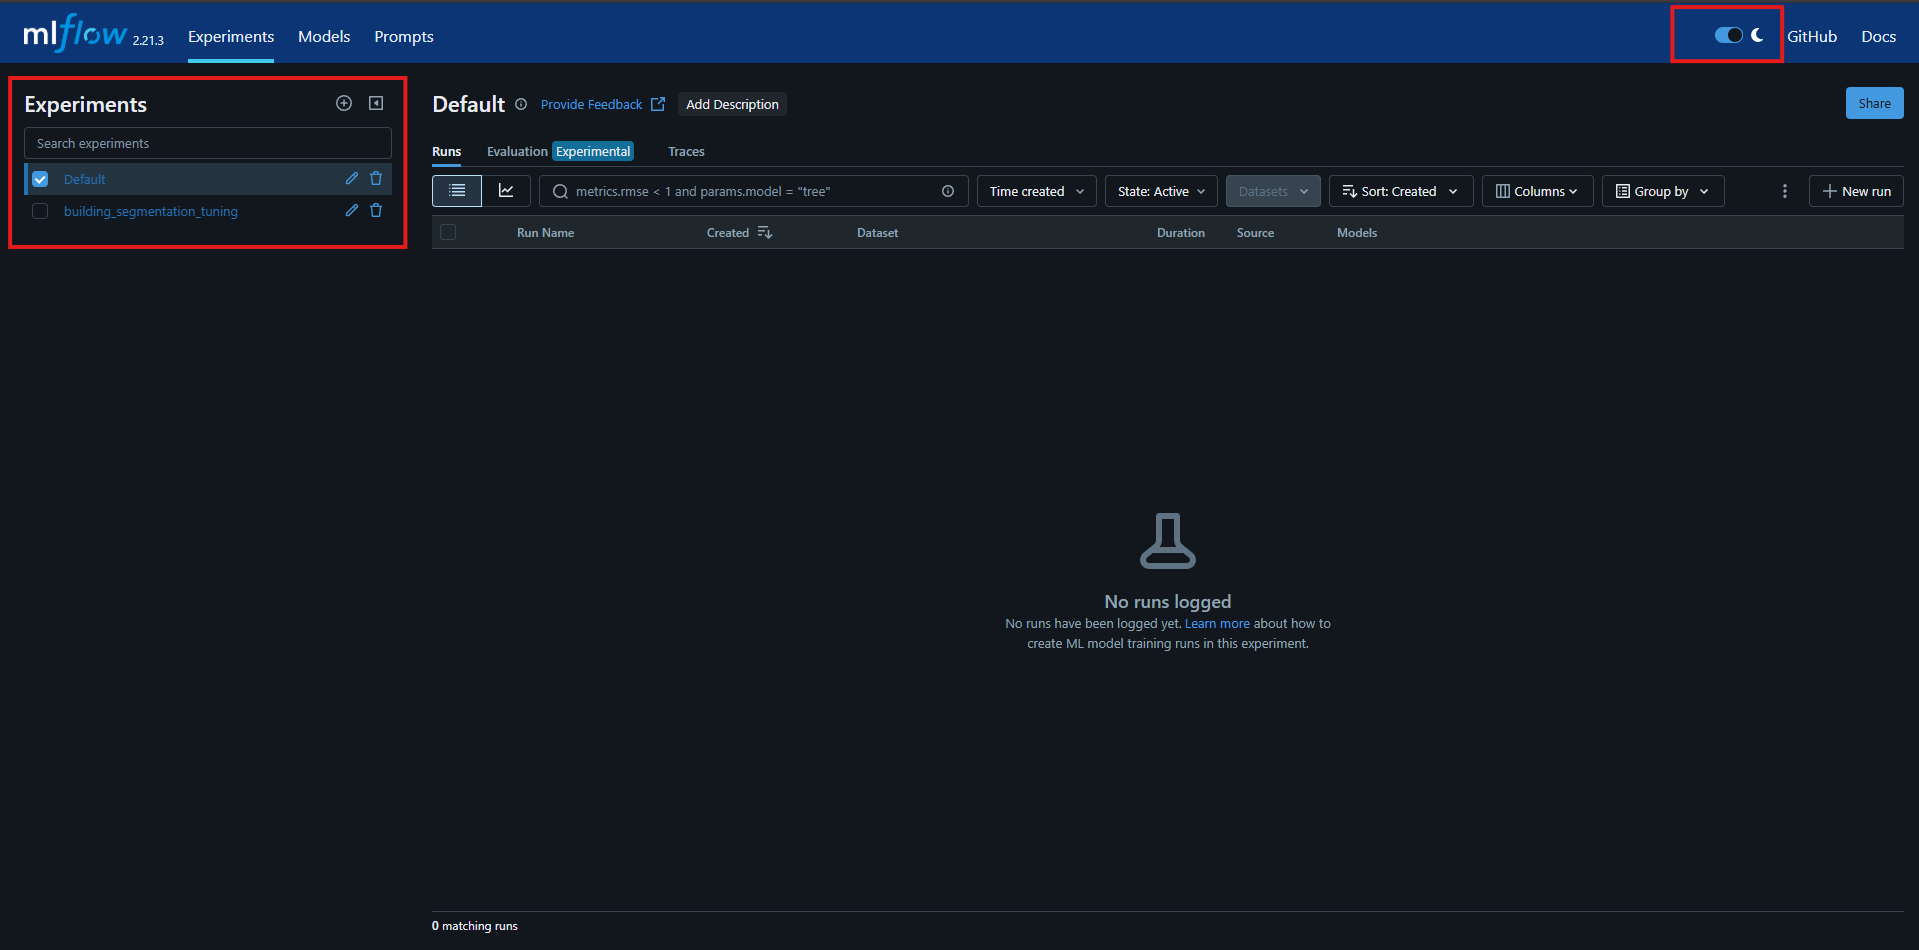

<figure style="text-align: center">
  <i>Homepage of MLFlow. Yours might seems a bit different.<br>
  On the top-left side, you can access different experiments. On the top-right side, you can toggle dark/light mode.
  </i>
</figure>

# Task 5: Analyzing Results with MLFlow UI

Running an experiment, especially for deep learning, is resource consumptive. If you are running this module in google colab, free version, you most likely run into crashing kernel. That is why we have prepared with you some successful run so you can still explore MLFlow UI.

**By default we won't run the experiment.**

If you still would like to try running the experiment, you can still do it by scrolling down to the bottom of the module, there is a ready-to-run cell to start the experiment.

Now that our experiments are complete, let's explore how to analyze the results using the MLFlow UI.

## Navigating the MLFlow UI

### Experiment View:

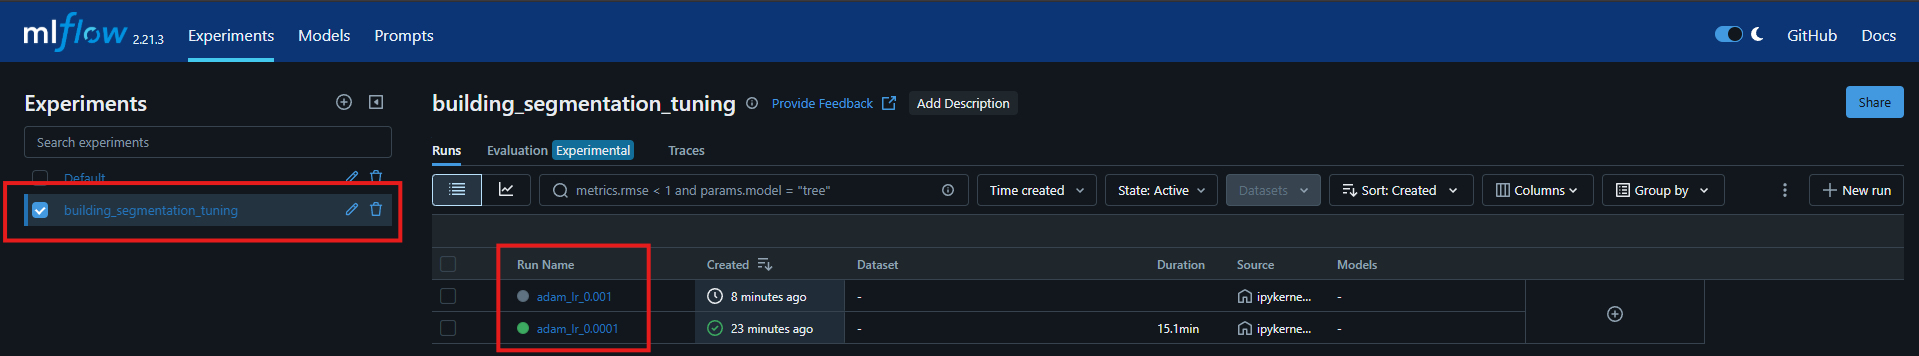

- Click on the "building_segmentation_tuning" experiment to see all runs
- Each run represents a different optimizer/learning rate combination
- The runs are named according to the configuration (e.g., "adam_lr_0.001")

### Comparing Runs:


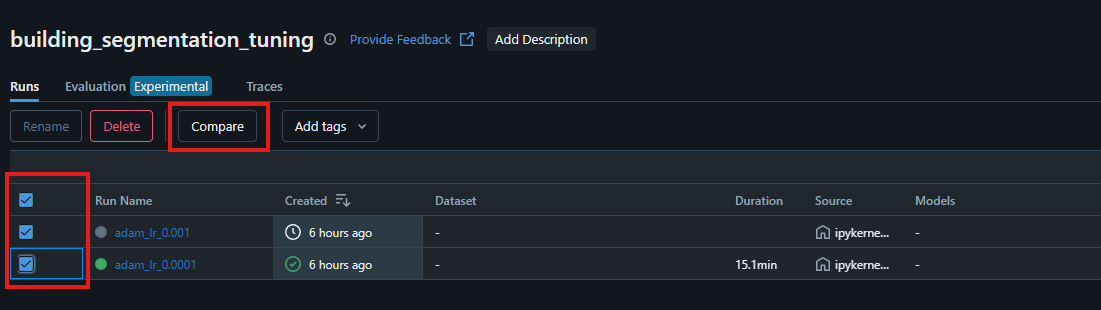

- Select the checkbox next to each run you want to compare
- Use the "Compare" button to compare runs


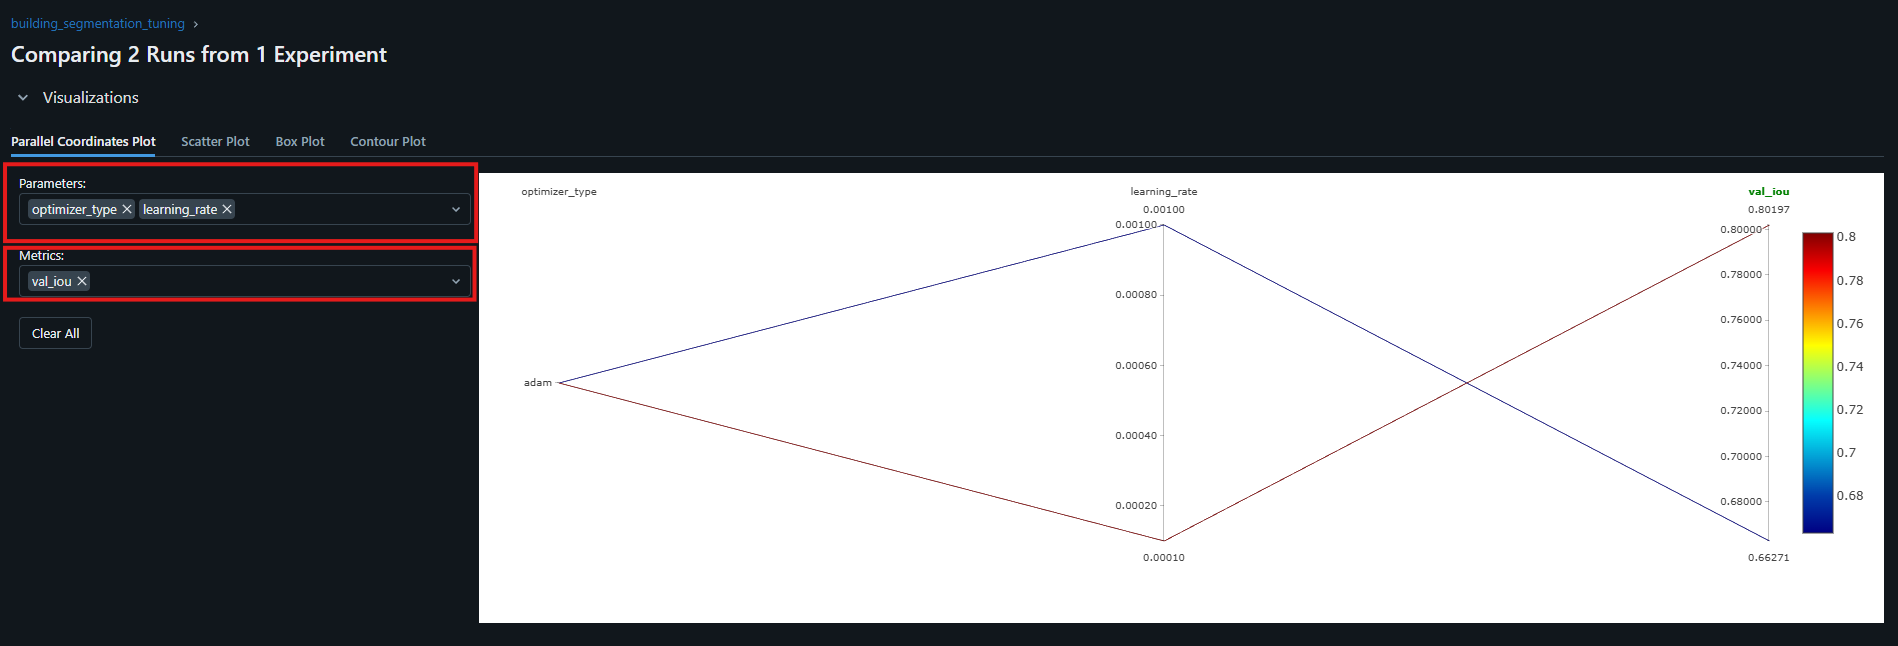

- In the `Parameters` form, fill in `optimizer_type` and `learning_rate`
- In the `Metrics` form, let's assume our most important metrics is `val_iou`
- Then you can analyze how different combinations of `Parameters` we run previously lead to different result in `Metrics`

### Exploring Metrics:

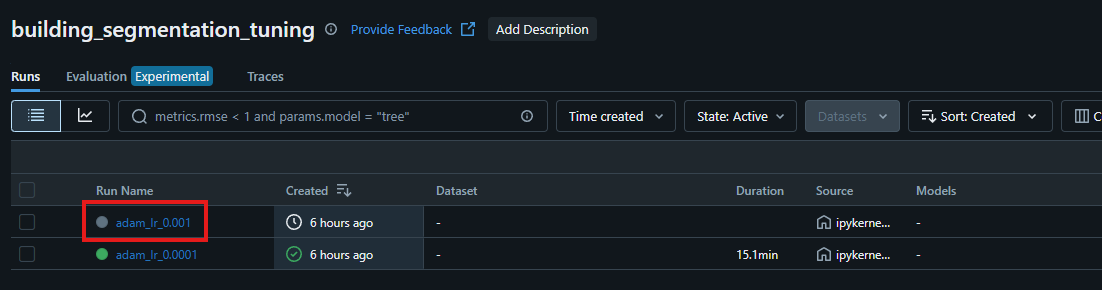

- Click on any individual run to see detailed information

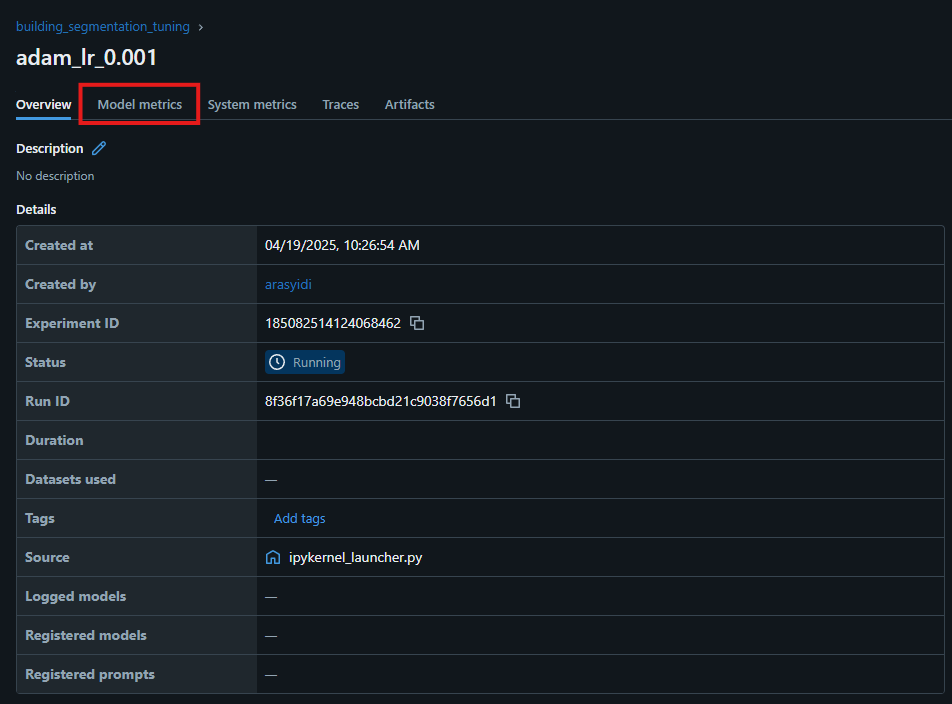

- You can read the `Overview` tab to see the overview of this run
- Navigate to the `Model Metrics` tab to see training and validation metrics
- Click on any metric to see its evolution over time

<div class="alert alert-block alert-success">
<h3>Excercise 1</h3>
Key Questions to Answer
</div>
Use the MLFlow UI to answer these questions based on your experiment result:

1. Which optimizer generally performed better, Adam or SGD?
1. What learning rate worked best for each optimizer?
1. How did the validation loss change over time for different configurations?
1. Did any runs show signs of overfitting (training loss decreasing while validation loss increases)?
1. Which configuration achieved the highest Dice score and IoU?

<details>
<summary>Click to see answer.</summary>

There's no _one_ correct answer for this one ;)

</details>

By exploring these questions through the MLFlow UI, you'll gain insights not just about which configuration performed best, but also about how different optimizers and learning rates affect the training dynamics of UNet models for semantic segmentation.

# 🎉 Congratulations on Completing the Module! 🎉

Well done! You've successfully completed the experimentation module for UNet semantic segmentation using MLFlow. This module has taken you through the essential process of hyperparameter experimentation and tracking your deep learning experiments.

Here's a summary of what we accomplished in this module:

1. **Understanding Experimentation in Deep Learning**
   - Learned the importance of hyperparameter tuning
   - Explored how hyperparameters impact model performance
   - Identified common pitfalls in experimentation
   - Set clear experimental goals for our segmentation task
1. **MLFlow Integration**
   - Set up MLFlow for experiment tracking
   - Learned how PyTorch Lightning integrates with MLFlow
   - Created a structured approach to log parameters and metrics
   - Used the MLFlow UI to visualize experiment results
1. **Structured Experimentation Plan**
   - Systematically tested different optimizer types (Adam vs SGD)
   - Experimented with various learning rates
   - Tracked key segmentation metrics (loss, Dice score, IoU)
   - Analyzed how different configurations affect performance
1. **Results Analysis**
   - Compared experiment results across different runs
   - Visualized training dynamics for different configurations

This experimentation process is a crucial skill for deep learning practitioners, allowing you to systematically improve model performance beyond the initial implementation. You now have the tools to approach any deep learning problem with a structured experimental mindset, tracking your progress and making data-driven decisions about model configurations.

# Further Reading

- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 1: Learning Curves](https://youtu.be/lYAV5KNk_TY?si=JHM_iQ7ol03e0xy_)
- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 2: Loss Curves](https://youtu.be/StNrJnL8eX0?si=yhvwLyXswdHst7E0)
- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 3: Validation Curves](https://youtu.be/wCBuc6Qc_wI?si=WgS0BPB_6b7umRsy)

# [OPTIONAL] Task 4: Run The Experiment!

After designing the experiment and setting up the MLFlow UI, we can finally run the experiment! This will take a while, since we are not running only one training but multiple! Four of them to be exact.

In [24]:
# this cell is meant to be error as a gate keeper to prevent unintentionally running the cells below (experiment part)
error will happen here

SyntaxError: invalid syntax (ipython-input-229536384.py, line 2)

## Creating a structured experimental plan

We'll use a simple grid of experiments:

In [25]:
# Define our experiment configurations
experiment_configs = [
    # Adam optimizer experiments
    {'optimizer_type': 'adam', 'learning_rate': 0.0001},
    {'optimizer_type': 'adam', 'learning_rate': 0.001},

    # SGD optimizer experiments
    {'optimizer_type': 'sgd', 'learning_rate': 0.0001},
    {'optimizer_type': 'sgd', 'learning_rate': 0.001},
]

In [ ]:
import gc

def empty_cache():#To avoid GPU memory issues
    gc.collect()
    torch.cuda.empty_cache()
# Run all experiments defined in our configuration grid
results = []

# We'll use fewer epochs for demonstration purposes
max_epochs = 2
empty_cache() #To avoid GPU memory issues
print("Starting experiments...")
for config in experiment_configs:
    optimizer_type = config['optimizer_type']
    learning_rate = config['learning_rate']

    print(f"\nRunning experiment with {optimizer_type} optimizer, learning rate = {learning_rate}")

    # Run the experiment and collect results
    result = run_experiment(
        optimizer_type=optimizer_type,
        learning_rate=learning_rate,
        max_epochs=max_epochs
    )
    empty_cache() #To avoid GPU memory issues
    # Store results for summary
    results.append(result)

    # # Display key metrics
    # print(f"Results: val_loss={result['val_loss']:.4f}, val_dice={result['val_dice']:.4f}, val_iou={result['val_iou']:.4f}")

print("\nAll experiments completed!")

Starting experiments...

Running experiment with adam optimizer, learning rate = 0.0001


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_dice          │            1.0            │
│          val_iou          │    0.6863853335380554     │
│         val_loss          │    0.2846698462963104     │
└───────────────────────────┴───────────────────────────┘

2025/08/29 18:53:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/29 18:53:35 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/29 18:53:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved in run bd66a927541e46b0964a353a1aa64057 with info: <mlflow.models.model.ModelInfo object at 0x7d79b9e28350>

Running experiment with adam optimizer, learning rate = 0.001


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode 
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results

# Clean UP

In [ ]:
shutil.rmtree(src_dir)
print(f"All data removed from {src_dir}")